# Quiz: Initialization of feed-forward neural network model

In this notebook, we demonstrate how different initialization schemes affect the accuracy of feed-forward neural network

The data in this example is taken from the GEFCom2014 forecasting competition<sup>1</sup>. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load. In this example, we show how to forecast one time step ahead, using historical load data only.

<sup>1</sup>Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

Please run this notebook after completing 0_data_setup notebook.

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from glob import glob
from collections import UserDict
from common.utils import load_data, mape
from IPython.display import Image
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

Load the data from csv into a Pandas dataframe

In [2]:
energy = load_data('data')[['load']]
energy.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


## Create train, validation and test sets

We separate our dataset into train, validation and test sets. We train the model on the train set. The validation set is used to evaluate the model after each training epoch and ensure that the model is not overfitting the training data. After the model has finished training, we evaluate the model on the test set. We must ensure that the validation set and test set cover a later period in time from the training set, to ensure that the model does not gain from information from future time periods.

We will allocate the period 1st November 2014 to 31st December 2014 to the test set. The period 1st September 2014 to 31st October is allocated to validation set. All other time periods are available for the training set.

In [3]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

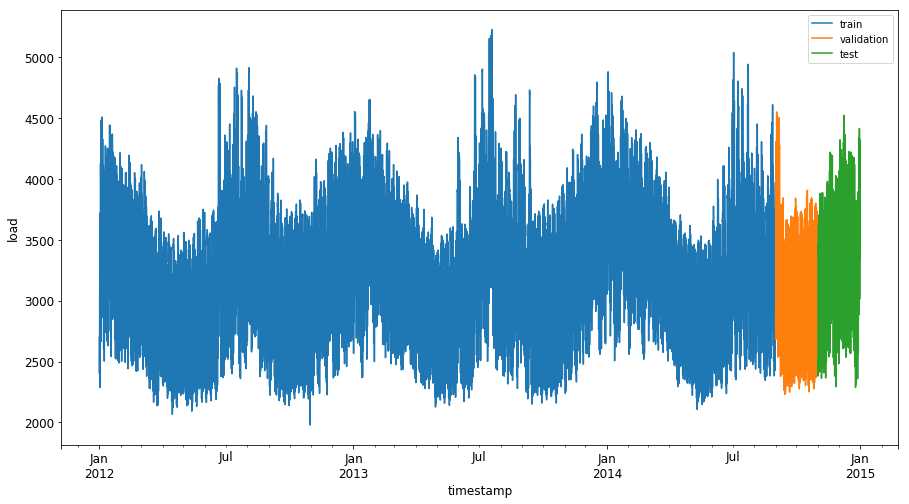

In [4]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'train'}) \
    .join(energy[(energy.index >=valid_start_dt) & (energy.index < test_start_dt)][['load']] \
          .rename(columns={'load':'validation'}), how='outer') \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'validation', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## Data preparation - training set

For this example, we will set *T=6*. This means that the input for each sample is a vector of the prevous 6 hours of the energy load. The choice of *T=6* was arbitrary but should be selected through experimentation.

*HORIZON=1* specifies that we have a forecasting horizon of 1 (*t+1*)

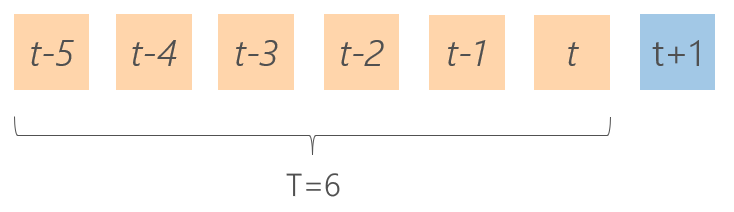

In [5]:
Image('./images/one_step_forecast.png')

In [6]:
T = 6
HORIZON = 1

Our data preparation for the training set will involve the following steps:

1. Filter the original dataset to include only that time period reserved for the training set
2. Scale the time series such that the values fall within the interval (0, 1)
3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
4. Discard any samples with missing values
5. Transform this Pandas dataframe into a numpy array of shape (samples, features) for input into Keras

### 1. Filter the original dataset to include only that time period reserved for the training set

Create training set containing only the model features

In [7]:
train = energy.copy()[energy.index < valid_start_dt][['load']]

### 2. Scale the time series such that the values fall within the interval (0, 1)

Scale data to be in range (0, 1). This transformation should be calibrated on the training set only. This is to prevent information from the validation or test sets leaking into the training data.

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

,load
2012-01-01 00:00:00,0.22
2012-01-01 01:00:00,0.18
2012-01-01 02:00:00,0.14
2012-01-01 03:00:00,0.13
2012-01-01 04:00:00,0.13
2012-01-01 05:00:00,0.15
2012-01-01 06:00:00,0.18
2012-01-01 07:00:00,0.23
2012-01-01 08:00:00,0.29
2012-01-01 09:00:00,0.35


Original vs scaled data:

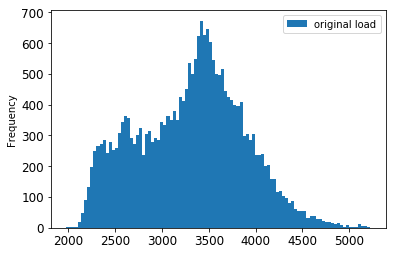

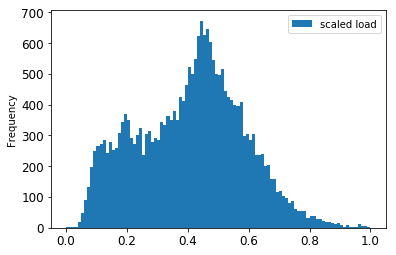

In [9]:
energy[energy.index < valid_start_dt][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

### 3. Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example

First, we create the target (*y_t+1*) variable. If we use the convention that the dataframe is indexed on time *t*, we need to shift the *load* variable forward one hour in time. Using the freq parameter we can tell Pandas that the frequency of the time series is hourly. This ensures the shift does not jump over any missing periods in the time series.

In [10]:
train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted['load'].shift(-1, freq='H')
train_shifted.head(10)

,load,y_t+1
2012-01-01 00:00:00,0.22,0.18
2012-01-01 01:00:00,0.18,0.14
2012-01-01 02:00:00,0.14,0.13
2012-01-01 03:00:00,0.13,0.13
2012-01-01 04:00:00,0.13,0.15
2012-01-01 05:00:00,0.15,0.18
2012-01-01 06:00:00,0.18,0.23
2012-01-01 07:00:00,0.23,0.29
2012-01-01 08:00:00,0.29,0.35
2012-01-01 09:00:00,0.35,0.37


We also need to shift the load variable back 6 times to create the input sequence:

In [11]:
for t in range(1, T+1):
    train_shifted[str(T-t)] = train_shifted['load'].shift(T-t, freq='H')

In [12]:
y_col = 'y_t+1'
X_cols = ['load_t-5',
          'load_t-4',
          'load_t-3',
          'load_t-2',
          'load_t-1',
          'load_t']
train_shifted.columns = ['load_original']+[y_col]+X_cols
train_shifted.head(10)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 00:00:00,0.22,0.18,nan,nan,nan,nan,nan,0.22
2012-01-01 01:00:00,0.18,0.14,nan,nan,nan,nan,0.22,0.18
2012-01-01 02:00:00,0.14,0.13,nan,nan,nan,0.22,0.18,0.14
2012-01-01 03:00:00,0.13,0.13,nan,nan,0.22,0.18,0.14,0.13
2012-01-01 04:00:00,0.13,0.15,nan,0.22,0.18,0.14,0.13,0.13
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


### 4. Discard any samples with missing values

Notice how we have missing values for the input sequences for the first 5 samples. We will discard these:

In [13]:
train_shifted = train_shifted.dropna(how='any')
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


### 5. Transform into a numpy arrays of shapes (samples, features) and (samples,1) for input into Keras

Now convert the target and input features into numpy arrays. 

In [14]:
y_train = train_shifted[[y_col]].as_matrix()
X_train = train_shifted[X_cols].as_matrix()

We now have a vector for target variable of shape:

In [15]:
y_train.shape

(23370, 1)

The target varaible for the first 3 samples looks like:

In [16]:
y_train[:3]

array([[0.18],
       [0.23],
       [0.29]])

The tensor for the input features now has the shape:

In [17]:
X_train.shape

(23370, 6)

And the first 3 samples looks like:

In [18]:
X_train[:3]

array([[0.22, 0.18, 0.14, 0.13, 0.13, 0.15],
       [0.18, 0.14, 0.13, 0.13, 0.15, 0.18],
       [0.14, 0.13, 0.13, 0.15, 0.18, 0.23]])

We can sense check this against the first 3 records of the original dataframe:

In [19]:
train_shifted.head(3)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23


## Data preparation - validation set

Now we follow a similar process for the validation set. We keep *T* hours from the training set in order to construct initial features.

In [20]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load']]
valid.head()

,load
2014-08-31 19:00:00,"3,969.00"
2014-08-31 20:00:00,"3,869.00"
2014-08-31 21:00:00,"3,643.00"
2014-08-31 22:00:00,"3,365.00"
2014-08-31 23:00:00,"3,097.00"


Scale the series using the transformer fitted on the training set:

In [21]:
valid['load'] = scaler.transform(valid)
valid.head()

,load
2014-08-31 19:00:00,0.61
2014-08-31 20:00:00,0.58
2014-08-31 21:00:00,0.51
2014-08-31 22:00:00,0.43
2014-08-31 23:00:00,0.34


Prepare validation inputs in the same way as the training set:

In [22]:
valid_shifted = valid.copy()
valid_shifted['y+1'] = valid_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    valid_shifted['load_t-'+str(T-t)] = valid_shifted['load'].shift(T-t, freq='H')
valid_shifted = valid_shifted.dropna(how='any')
y_valid = valid_shifted['y+1'].as_matrix()
X_valid = valid_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()

In [23]:
y_valid.shape

(1463,)

In [24]:
X_valid.shape

(1463, 6)

## Implement Feedforward Neural Network

We implement feed-forward neural network with the 6 inputs, 3 hidden layers, 5 neurons in eachhidden layer and one neuron in output layer.

In [25]:
from keras import regularizers
from keras.models import Model, Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import initializers

Using TensorFlow backend.


In [26]:
LATENT_DIM = 5 # number of units in the dense layer
BATCH_SIZE = 32 # number of samples per mini-batch
EPOCHS = 50 # maximum number of times the training algorithm will cycle through all samples

#### Quiz: Run the code below with initializers.Zeros() , initializers.RandomNormal() and initializers.glorot_uniform(). Check MAPE value at the end of the notebook.

In [ ]:
model = Sequential()
init = initializers.glorot_uniform()   # CHANGE ONLY THIS LINE
model.add(Dense(LATENT_DIM, activation="relu", input_shape=(T,), 
                kernel_initializer=init,bias_initializer=init))
model.add(Dense(HORIZON))

Use RMSprop optimizer and mean squared error as the loss function. 

In [ ]:
model.compile(optimizer='RMSprop', loss='mse')

In [ ]:
model.summary()

#### Early stopping trick

In [ ]:
Image('./images/early_stopping.png')

Specify the early stopping criteria. We **monitor** the validation loss (in this case the mean squared error) on the validation set after each training epoch. If the validation loss has not improved by **min_delta** after **patience** epochs, we stop the training.

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [ ]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [ ]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop, best_val],
                    verbose=1)

Load the model with the smallest mape

In [ ]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

plot training and validation losses

In [ ]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

clean up model files

In [ ]:
for m in glob('model_*.h5'):
    os.remove(m)

## Evaluate the model

Create the test set

In [ ]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load']]
test.head()

Scale the test data

In [ ]:
test['load'] = scaler.transform(test)
test.head()

Create test set features

In [ ]:
test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted['load'].shift(-1, freq='H')
for t in range(1, T+1):
    test_shifted['load_t-'+str(T-t)] = test_shifted['load'].shift(T-t, freq='H')
test_shifted = test_shifted.dropna(how='any')
y_test = test_shifted['y_t+1'].as_matrix()
X_test = test_shifted[['load_t-'+str(T-t) for t in range(1, T+1)]].as_matrix()

Make predictions on test set

In [ ]:
predictions = model.predict(X_test)
predictions

Compare predictions to actual load

In [ ]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

Compute the mean absolute percentage error over all predictions

In [ ]:
mape(eval_df['prediction'], eval_df['actual'])